# Graphs and Networks

In [1]:
import json

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg

Representing graphs as adjacency matrices is another important application of sparse
matrices. In an adjacency matrix, an element describes which nodes in a graph are
connected to each other. Consequently, if each node is only connected to a small set of
other nodes, the adjacency matrix is sparse. The `csgraph` module in the SciPy sparse
module provides functions for processing such graphs, including methods for traversing
a graph using different methods (e.g., breadth-first and depth-first traversals) and for
computing shortest paths between nodes in a graph, and so on. For more information
about this module, refer to its docstring: help(`sp.csgraph`)

For a more comprehensive framework for working with graphs, there is the
NetworkX Python library. It provides utilities for creating and manipulating undirected
and directed graphs and also implements many graph algorithms, such as finding
minimum paths between nodes in a graph. Here we assume that the Networkx library
is imported under the name `nx`. Using this library, we can, for example, create an
undirected graph by initiating an object of the class `nx.Graph`. Any hashable Python
object can be stored as nodes in a graph object, which makes it a very flexible data
structure. However, in the following examples, we only use graph objects with integers
and strings as node labels. See Table 10-2 for a summary of functions for creating graphs
and for adding nodes and edges to graph objects.

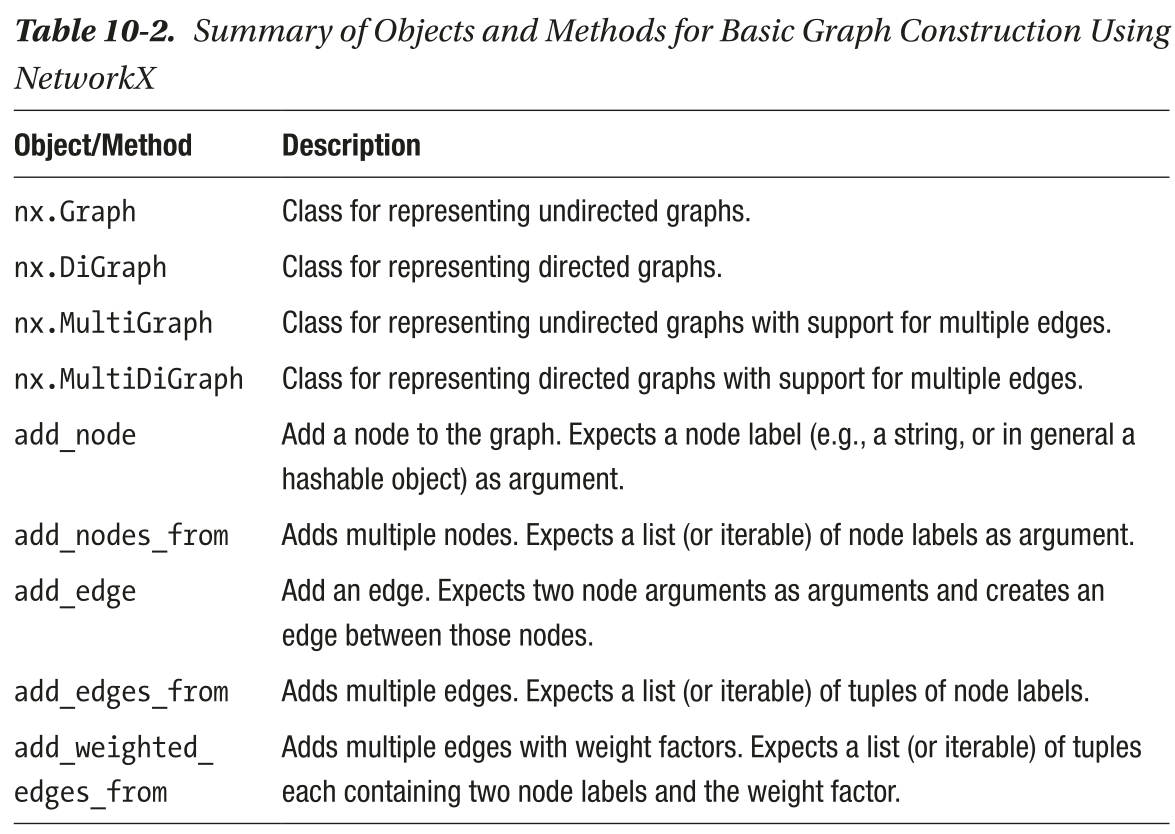

For example, we can create a simple graph with node data that are integers using
`nx.Graph()`, and the `add_node` method, or `add_nodes_from` to add multiple nodes in one
go. The nodes method returns an iterator object for the nodes, called a `NodeView`:

In [2]:
g = nx.Graph()
g.add_node(1)
g.nodes()

NodeView((1,))

In [3]:
g.add_nodes_from([3, 4, 5])
g.nodes()

NodeView((1, 3, 4, 5))

To connect nodes we can add edges, using `add_edge`. We pass the labels
of the two nodes we want to connect as arguments. To add multiple edges, we can use
`add_edges_from` and pass to it a list of tuples of nodes to connect. The edges method
returns an iterator object for the edges, called `EdgeView`

In [4]:
g.add_edge(1, 2)
g.edges()

EdgeView([(1, 2)])

In [5]:
g.add_edges_from([(3, 4), (5, 6)])
g.edges()

EdgeView([(1, 2), (3, 4), (5, 6)])

To represent edges between nodes that have weights associated with them (e.g., a
distance), we can use `add_weighted_edges_from`, to which we pass a list of tuples that
also contains the weight factor for each edge, in addition to the two nodes. When calling
the edges method, we can additionally give argument `data=True` to indicate that also the
edge data should be included in the resulting view

In [6]:
g.add_weighted_edges_from([(1, 3, 1.5), (3, 5, 2.5)])

# To add info about date
g.edges(data=True)

EdgeDataView([(1, 2, {}), (1, 3, {'weight': 1.5}), (3, 4, {}), (3, 5, {'weight': 2.5}), (5, 6, {})])

Note that if we add edges between nodes that do not yet exist in the graph, they are
seamlessly added. For example, in the following code, we add a weighted edge between
nodes 6 and 7. Node 7 does not previously exist in the graph, but when adding an edge to
it, it is automatically created and added to the graph

In [7]:
g.add_weighted_edges_from([(6, 7, 1.5)])

g.edges(data=True)

EdgeDataView([(1, 2, {}), (1, 3, {'weight': 1.5}), (3, 4, {}), (3, 5, {'weight': 2.5}), (5, 6, {}), (6, 7, {'weight': 1.5})])

With these basic fundamentals in place, we are already prepared to look at a more
complicated example of a graph. In the following we will build a graph from a dataset
stored in a JSON file called `tokyo-metro.json` (available together with the code listings),
which we load using the Python standard library module json

In [8]:
with open("tokyo-metro.json") as file:
    data = json.load(file)

### Let's play with JSON

In [9]:
data.keys()

dict_keys(['C', 'G', 'F', 'H', 'M', 'N', 'T', 'Y', 'Z'])

In [10]:
data["C"]["color"]

'#149848'

In [11]:
d = list(data.values())
# Station1, Station2, Weights
d[1]["travel_times"][1:3]

[['G2', 'G3', 1], ['G3', 'G4', 2]]

Here the format of the travel_times list is `[['C1', 'C2', 2], ['C2', 'C3', 2], ...]`,
indicating that it takes 2 minutes to travel between the stations `C1` and `C2`, and 2 minutes
to travel between `C2` and `C3`, etc. The format of the transfers list is `[['C3', 'F15'], ...]`,
indicating that it is possible to transfer from the `C` line to the `F` line at station `C3` to
station `F15`. The `travel_times` and `transfers` are directly suitable for feeding to
`add_weighed_edges_from` and `add_edges_from`, and we can therefore easily create a
graph for representing the metro network by iterating over each metro line dictionary
and call these methods:

In [12]:
g = nx.Graph()

for line in data.values():
    g.add_weighted_edges_from(line["travel_times"])
    g.add_edges_from(line["transfers"])

# C1 and C1 stations
g.edges(("C1", "C2"), data=True)

EdgeDataView([('C1', 'C2', {'weight': 2}), ('C2', 'C3', {'weight': 2})])

The line transfer edges do not have edge weights, so let’s first mark all transfer edges
by adding a new `Boolean` attribute transfer to each edge

In [13]:
for n1, n2 in g.edges():
    g[n1][n2]["transfer"] = "weight" not in g[n1][n2]

# C1 and C1 stations data output
g.edges(("C1", "C2"), data=True)

EdgeDataView([('C1', 'C2', {'weight': 2, 'transfer': False}), ('C2', 'C3', {'weight': 2, 'transfer': False})])

In [14]:
on_foot = [e for e in g.edges() if g.get_edge_data(*e)["transfer"]]
on_train = [e for e in g.edges() if not g.get_edge_data(*e)["transfer"]]

In [15]:
list(g.nodes())[0]

'C1'

In [16]:
data["C"]["color"]

'#149848'

In [17]:
colors = [data[n[0].upper()]["color"] for n in g.nodes()]
colors[1:3]

['#149848', '#149848']

To visualize the graph, we can use the Matplotlib-based drawing routines in the
Networkx library: we use `nx.draw` to draw each node, `nx.draw_networkx_labels` to
draw the labels to the nodes, and `nx.draw_network_edges` to draw the edges. We call
`nx.draw_network_edges` twice, with the edge lists for transfers (on_foot) and on-train
(on_train) connections, and color the links as blue and black, respectively, using the
`edge_color` argument. The layout of the graph is determined by the `pos` argument to
the drawing functions. Here we used the `graphviz_layout` function from `networkx.drawing.nx_agraph`
to lay out the nodes. All drawing functions also accept a Matplotlib
axes instance via the ax argument. The resulting graph is shown in Figure 10-5.

How to install pygraphviz https://pygraphviz.github.io/documentation/stable/install.html

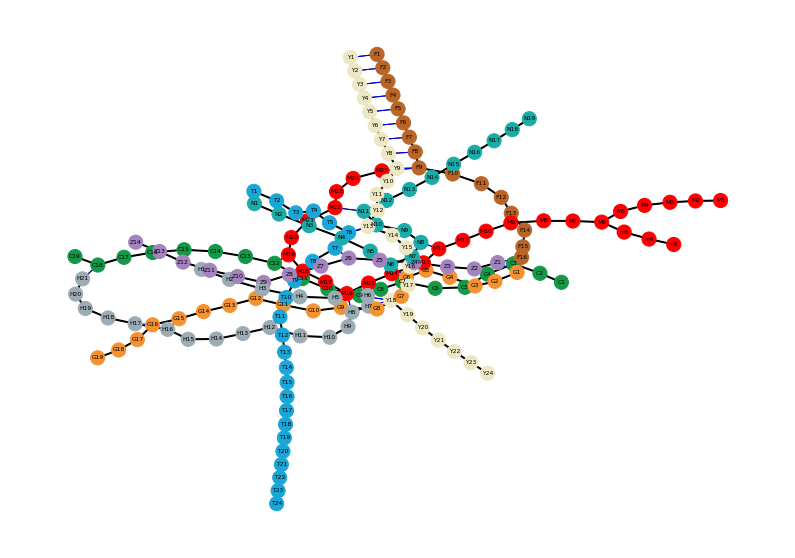

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
pos = nx.drawing.nx_agraph.graphviz_layout(g, prog="neato")

nx.draw(g, pos, ax=ax, node_size=200, node_color=colors)
nx.draw_networkx_labels(g, pos=pos, ax=ax, font_size=6)

nx.draw_networkx_edges(g, pos=pos, ax=ax, edgelist=on_train, width=2)
nx.draw_networkx_edges(g, pos=pos, ax=ax, edgelist=on_foot, edge_color="blue")

> Network graph for the Tokyo Metro stations

Once the network has been constructed, we can use the many graph algorithms
provided by the NetworkX library to analyze the network. For example, to compute the
degree (i.e., the number of connections to a node) of each node, we can use the `degree`
method (here the output is truncated at ... to save space)

In [19]:
list(g.degree())[1:3]

[('C2', 2), ('C3', 3)]

For this graph, the degree of a node can be interpreted as the number of connections
to a station: the more metro lines that connect at a station, the higher the degree of the
corresponding node. We can easily search for the most highly connected station in the
network by using the `degree` method and the `max` function to find the highest degree
in the network. Next we iterate over the result of the degree method and select out the
nodes with the maximal degree (which is 6 in this network):

In [20]:
d_max = max(d for (n, d) in g.degree())

[(n, d) for (n, d) in g.degree() if d == d_max]

[('G5', 6), ('M13', 6), ('Y16', 6), ('Z4', 6), ('N7', 6)]

The result tells us that the most highly connected stations are station numbers 7 on
the `N` line, 5 on the `G` line, and so on. All these lines intercept at the same station (the
*Nagatachou* station). We can also compute the closest path between two points in the
network using `nx.shortest_path`. For example, the optimal traveling route (assuming
no waiting time and instantaneous transfer) for traveling between `Y24` and `C19` is

In [21]:
p = nx.shortest_path(g, "Y24", "C19")
p[1:4]

['Y23', 'Y22', 'Y21']

In [22]:
def get_weights(g, p):
    return [
        g[p[n]][p[n + 1]]["weight"]
        for n in range(len(p) - 1)
        if "weight" in g[p[n]][p[n + 1]]
    ]

In [23]:
def sum_path_weights(g, p):
    return sum(get_weights(g, p))

Given a path on this form, we can also directly evaluate the travel time by summing
up the weight attributes of neighboring nodes in the path

In [24]:
weights = get_weights(g, p)
weights

[2, 3, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3]

In [25]:
sum_path_weights(g, p)

35

The result suggests that it takes 35 minutes to travel from `Y24` to `C19`. Since the
transfer nodes do not have a weight associated with them, the train transfers are
effectively assumed to be instantaneous. It may be reasonable to assume that a train
transfer takes about 5 minutes, and to take this into account in the shortest path and
travel time computation, we can update the transfer nodes and add a weight of 5 to
each of them. To do this we create a copy of the graph using the copy method and iterate
through the edges and update those with transfer attribute set to `True`

In [26]:
h = g.copy()

for n1, n2 in h.edges():
    if h[n1][n2]["transfer"]:
        h[n1][n2]["weight"] = 5

Recomputing the path and the traveling time with the new graph gives a more
realistic estimate of the traveling time:

In [27]:
p = nx.shortest_path(h, "Y24", "C19")
p

['Y24',
 'Y23',
 'Y22',
 'Y21',
 'Y20',
 'Y19',
 'Y18',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'C15',
 'C16',
 'C17',
 'C18',
 'C19']

In [28]:
sum_path_weights(h, p)

40

With this method, we can of course compute the optimal path and travel time
between arbitrary nodes in the network. As another example, we also compute the
shortest path and traveling time between `Z1` and `H16` (32 minutes):

In [29]:
p = nx.shortest_path(h, "Z1", "H16")
np.sum(get_weights(h, p))

32

The NetworkX representation of a graph can be converted to an adjacency matrix in
the form of a SciPy sparse matrix using the `nx.to_scipy_sparse_matrix`, after which we
can also analyze the graph with the routines in the `sp.csgraph` module. As an example
of this, we convert the Tokyo Metro graph to an adjacency matrix and compute its
reverse Cuthill-McKee ordering (using `sp.csgraph.reverse_cuthill_mckee`, which
is a reordering that reduces the maximum distance of the matrix elements from the
diagonal) and permute the matrix with this ordering. We plot the result of both matrices
using Matplotlib’s spy function, and the result is shown in Figure 10-6.

In [39]:
A = nx.to_scipy_sparse_matrix(g, format="csr")
A

<184x184 sparse matrix of type '<class 'numpy.int64'>'
	with 486 stored elements in Compressed Sparse Row format>

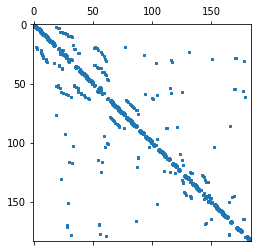

In [46]:
perm = sp.csgraph.reverse_cuthill_mckee(A)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.spy(A, markersize=2)